In [ ]:
!pip install matplotlib tqdm pillow

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
import logging
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import crop
from tqdm import tqdm


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [3]:
image_dir = '../Data/Picture_Caustic'
mask_dir = '../Data/Caustic_Seg'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Validate that each image has a corresponding mask
valid_pairs = [(img, img) for img in image_files if img in mask_files]

print(f"Found {len(valid_pairs)} valid image-mask pairs out of {len(image_files)} images.")

Found 1066 valid image-mask pairs out of 1066 images.


In [57]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, indices=None, transform=None, crop_size=(256, 256), max_blur_radius=2, is_train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.crop_size = crop_size
        self.max_blur_radius = max_blur_radius
        self.is_train = is_train
        
        # Load images and masks into a dictionary
        self.data_dict = self._load_data()
        self.images = list(self.data_dict.keys())

        # Subset the dataset based on provided indices
        if indices is not None:
            self.images = [self.images[i] for i in indices]

    def _load_data(self):
        data_dict = {}
        image_files = os.listdir(self.image_dir)
        
        for img_name in image_files:
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)
            
            if os.path.exists(mask_path):
                image = Image.open(img_path).convert("RGB")
                mask = Image.open(mask_path).convert("L")
                data_dict[img_name] = (image, mask)
        
        return data_dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image, mask = self.data_dict[img_name]
        
        if self.is_train:
            # Determine the crop size dynamically
            original_width, original_height = image.size
            crop_width = random.randint(int(original_width * 0.25), original_width)
            crop_height = random.randint(int(original_height * 0.25), original_height)
            
            # Apply random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_height, crop_width))
            image = transforms.functional.crop(image, i, j, h, w)
            mask = transforms.functional.crop(mask, i, j, h, w)
            
            # Apply random blur to the image
            blur_radius = random.uniform(0, self.max_blur_radius)
            image = image.filter(ImageFilter.GaussianBlur(blur_radius))
            
            # Apply random horizontal flip with 50/50 chance
            if random.random() > 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [58]:
def create_split_directories(full_dataset, base_dir, train_indices, val_indices, test_indices):
    """Create directories for train, val, and test splits and copy images and masks."""
    for split, indices in zip(['train', 'val', 'test'], [train_indices, val_indices, test_indices]):
        split_dir = os.path.join(base_dir, split)
        img_split_dir = os.path.join(split_dir, 'imgs')
        mask_split_dir = os.path.join(split_dir, 'masks')
        
        os.makedirs(img_split_dir, exist_ok=True)
        os.makedirs(mask_split_dir, exist_ok=True)
        
        for idx in indices:
            img_name = full_dataset.images[idx]
            img_src = os.path.join(image_dir, img_name)
            mask_src = os.path.join(mask_dir, img_name)
            
            img_dst = os.path.join(img_split_dir, img_name)
            mask_dst = os.path.join(mask_split_dir, img_name)
            
            shutil.copy(img_src, img_dst)
            shutil.copy(mask_src, mask_dst)

In [59]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

full_dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
full_dataloader = DataLoader(full_dataset, batch_size=4, shuffle=True)

In [60]:
# Test the dataloader
def testing_dataloader(dataloader):
    for i, (images, masks) in enumerate(dataloader):
        print(f'Batch {i+1}')
        print(f'Images shape: {images.shape}')
        print(f'Masks shape: {masks.shape}')
        if i == 2:  # Test with the first 3 batches
            break

In [61]:
print("Testing full dataloader")
testing_dataloader(full_dataloader)

Testing full dataloader
Batch 1
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 2
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 3
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])


In [62]:
# Split dataset into train, val, and test sets
train_val_indices, test_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [63]:
# Create split directories and copy data
base_dir = '../Data/split'
create_split_directories(full_dataset, base_dir, train_indices, val_indices, test_indices)

In [64]:
# Define paths for splits
train_image_dir = os.path.join(base_dir, 'train', 'imgs')
train_mask_dir = os.path.join(base_dir, 'train', 'masks')
val_image_dir = os.path.join(base_dir, 'val', 'imgs')
val_mask_dir = os.path.join(base_dir, 'val', 'masks')
test_image_dir = os.path.join(base_dir, 'test', 'imgs')
test_mask_dir = os.path.join(base_dir, 'test', 'masks')

In [65]:
# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_image_dir, train_mask_dir, transform=transform)
val_dataset = SegmentationDataset(val_image_dir, val_mask_dir, transform=transform)
test_dataset = SegmentationDataset(test_image_dir, test_mask_dir, transform=transform)

In [66]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [67]:
print("Testing train_dataloader")
testing_dataloader(train_dataloader)

print("Testing val_dataloader")
testing_dataloader(val_dataloader)

Testing train_dataloader
Batch 1
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 2
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 3
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Testing val_dataloader
Batch 1
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 2
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])
Batch 3
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])


Training Samples:


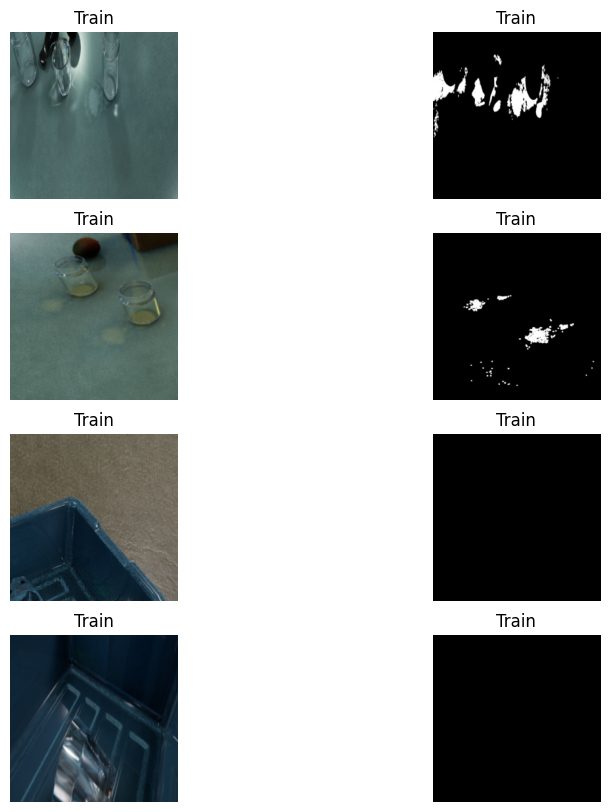

Validation Samples:


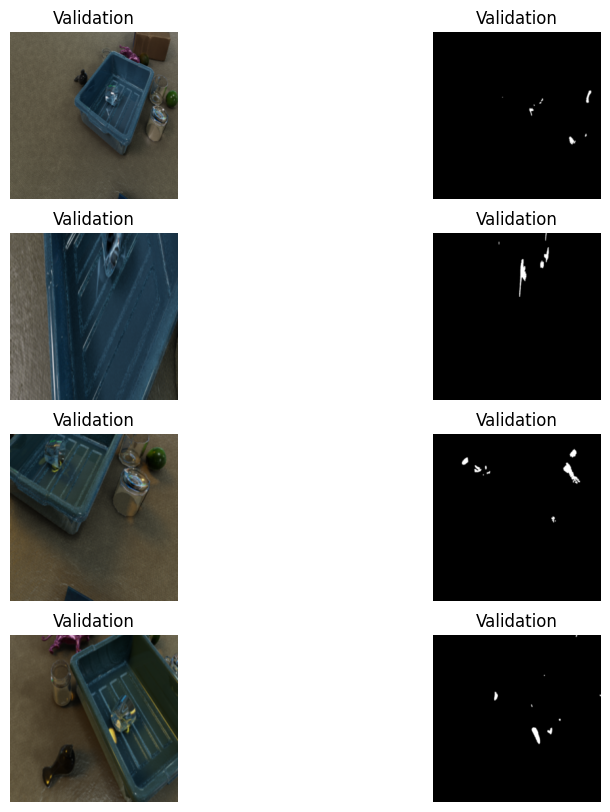

Testing Samples:


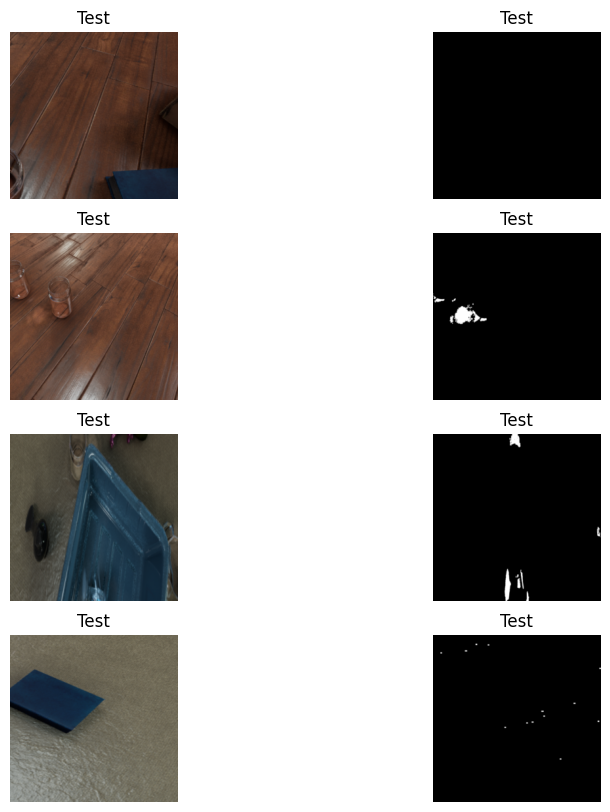

In [68]:
# Display some sample images and masks from the training dataset
def show_sample_images(dataset, title, num_samples=4):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
    for i in range(num_samples):
        img, mask = dataset[i]
        ax[i, 0].imshow(img.permute(1, 2, 0))
        ax[i, 0].set_title(title)
        ax[i, 0].axis('off')  
        
        ax[i, 1].imshow(mask.squeeze(), cmap='gray')
        ax[i, 1].set_title(title)
        ax[i, 1].axis('off')
    plt.show()

print("Training Samples:")
show_sample_images(train_dataset, "Train")

print("Validation Samples:")
show_sample_images(val_dataset, "Validation")

print("Testing Samples:")
show_sample_images(test_dataset, "Test")

In [69]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [70]:
class DownSampleLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSampleLayer, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [71]:
class UpSampleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpSampleLayer, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [72]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [73]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSampleLayer(64, 128)
        self.down2 = DownSampleLayer(128, 256)
        self.down3 = DownSampleLayer(256, 512)
        self.down4 = DownSampleLayer(512, 512)
        self.up1 = UpSampleLayer(1024, 256)
        self.up2 = UpSampleLayer(512, 128)
        self.up3 = UpSampleLayer(256, 64)
        self.up4 = UpSampleLayer(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
torch.cuda.is_available()

True

In [76]:
def evaluate_model(model, dataloader):
    model.eval()
    total_iou = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, masks in dataloader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5

            iou = calculate_iou(preds, masks)
            total_iou += iou * inputs.size(0)
            total_samples += inputs.size(0)
    
    avg_iou = total_iou / total_samples
    return avg_iou

def calculate_iou(preds, masks):
    preds = preds.int()
    masks = masks.int()
    intersection = (preds & masks).float().sum((1, 2))
    union = (preds | masks).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [77]:
def get_optimizer(optimizer_name, model_parameters, lr, weight_decay):
    if optimizer_name == 'adam':
        return optim.Adam(model_parameters, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model_parameters, lr=lr, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [78]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, masks in progress_bar:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        logging.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [83]:
def grid_search(param_grid, train_dataset, val_dataset, num_folds=5):
    best_params = None
    best_val_loss = float('inf')
    results = []
    
    for params in param_grid:
        logging.info(f"Testing hyperparameters: {params}")
        fold_results = []

        criterion = nn.BCEWithLogitsLoss()
        optimizer = get_optimizer(params['optimizer'], model.parameters(), params['lr'], params['weight_decay'])

        train_model(model, criterion, optimizer, train_dataloader, num_epochs=params['num_epochs'])
        val_loss = evaluate_model(model, val_dataloader)
        fold_results.append(val_loss)

        logging.info(f'Fold Validation Loss: {val_loss:.4f}')

        avg_val_loss = np.mean(fold_results)
        results.append((params, avg_val_loss))
        logging.info(f"Average Validation Loss for params {params}: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = params

    logging.info(f"Best hyperparameters: {best_params} with validation loss: {best_val_loss:.4f}")
    return best_params, results

In [84]:
param_grid = [
    {'lr': 0.001, 'batch_size': 4, 'optimizer': 'adam', 'weight_decay': 0, 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0, 'num_epochs': 15},
    {'lr': 0.0001, 'batch_size': 4, 'optimizer': 'adam', 'weight_decay': 0, 'num_epochs': 10},
    
    {'lr': 0.001, 'batch_size': 4, 'optimizer': 'adam', 'weight_decay': 0.0001, 'num_epochs': 15},
    {'lr': 0.001, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0001, 'num_epochs': 10},
    {'lr': 0.0001, 'batch_size': 4, 'optimizer': 'adam', 'weight_decay': 0.0001, 'num_epochs': 25},
    {'lr': 0.0001, 'batch_size': 8, 'optimizer': 'adam', 'weight_decay': 0.0001, 'num_epochs': 30},
    {'lr': 0.001, 'batch_size': 4, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 10},
    {'lr': 0.001, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 15},
    {'lr': 0.0001, 'batch_size': 4, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 25},
    {'lr': 0.0001, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 25},
    {'lr': 0.00001, 'batch_size': 4, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 10},
    {'lr': 0.00001, 'batch_size': 8, 'optimizer': 'sgd', 'weight_decay': 0.0001, 'num_epochs': 25},
]

In [28]:
train_model(model, criterion, optimizer, train_dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 160/160 [00:14<00:00, 11.38it/s, loss=0.0608]
2024-06-24 17:01:40,007 - Epoch 1/10, Loss: 0.1897
Epoch 2/10: 100%|██████████| 160/160 [00:13<00:00, 11.97it/s, loss=0.111] 
2024-06-24 17:01:53,380 - Epoch 2/10, Loss: 0.0653
Epoch 3/10: 100%|██████████| 160/160 [00:13<00:00, 11.76it/s, loss=0.069] 
2024-06-24 17:02:06,991 - Epoch 3/10, Loss: 0.0578
Epoch 4/10: 100%|██████████| 160/160 [00:13<00:00, 11.78it/s, loss=0.023] 
2024-06-24 17:02:20,576 - Epoch 4/10, Loss: 0.0565
Epoch 5/10: 100%|██████████| 160/160 [00:13<00:00, 11.73it/s, loss=0.0552]
2024-06-24 17:02:34,220 - Epoch 5/10, Loss: 0.0563
Epoch 6/10: 100%|██████████| 160/160 [00:13<00:00, 11.62it/s, loss=0.0332]
2024-06-24 17:02:47,992 - Epoch 6/10, Loss: 0.0583
Epoch 7/10: 100%|██████████| 160/160 [00:13<00:00, 11.71it/s, loss=0.106] 
2024-06-24 17:03:01,655 - Epoch 7/10, Loss: 0.0557
Epoch 8/10: 100%|██████████| 160/160 [00:13<00:00, 11.53it/s, loss=0.0275]
2024-06-24 17:03:15,537 - Epoch 8/10, Loss:

In [133]:
# Evaluate the final model on the test dataset
test_loss = evaluate_model(final_model, test_dataloader)
logging.info(f'Test Loss: {test_loss:.4f}')

# Evaluate the final model on the test dataset
test_loss2 = evaluate_model(model, test_dataloader)
logging.info(f'Test Loss: {test_loss2:.4f}')

2024-06-25 01:12:57,566 - Test Loss: 0.9019


In [130]:
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    with torch.no_grad():
        for i, (inputs, masks) in enumerate(dataloader):
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.07

            for j in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return
                axes[images_so_far, 0].imshow(inputs.cpu().data[j].permute(1, 2, 0))
                axes[images_so_far, 0].set_title("Input Image")
                axes[images_so_far, 0].axis('off')
                axes[images_so_far, 1].imshow(masks.cpu().data[j].squeeze(), cmap='gray')
                axes[images_so_far, 1].set_title("Ground Truth Mask")
                axes[images_so_far, 1].axis('off')
                axes[images_so_far, 2].imshow(preds.cpu().data[j].squeeze(), cmap='gray')
                axes[images_so_far, 2].set_title("Predicted Mask")
                axes[images_so_far, 2].axis('off')
                images_so_far += 1
    plt.tight_layout()
    plt.show()

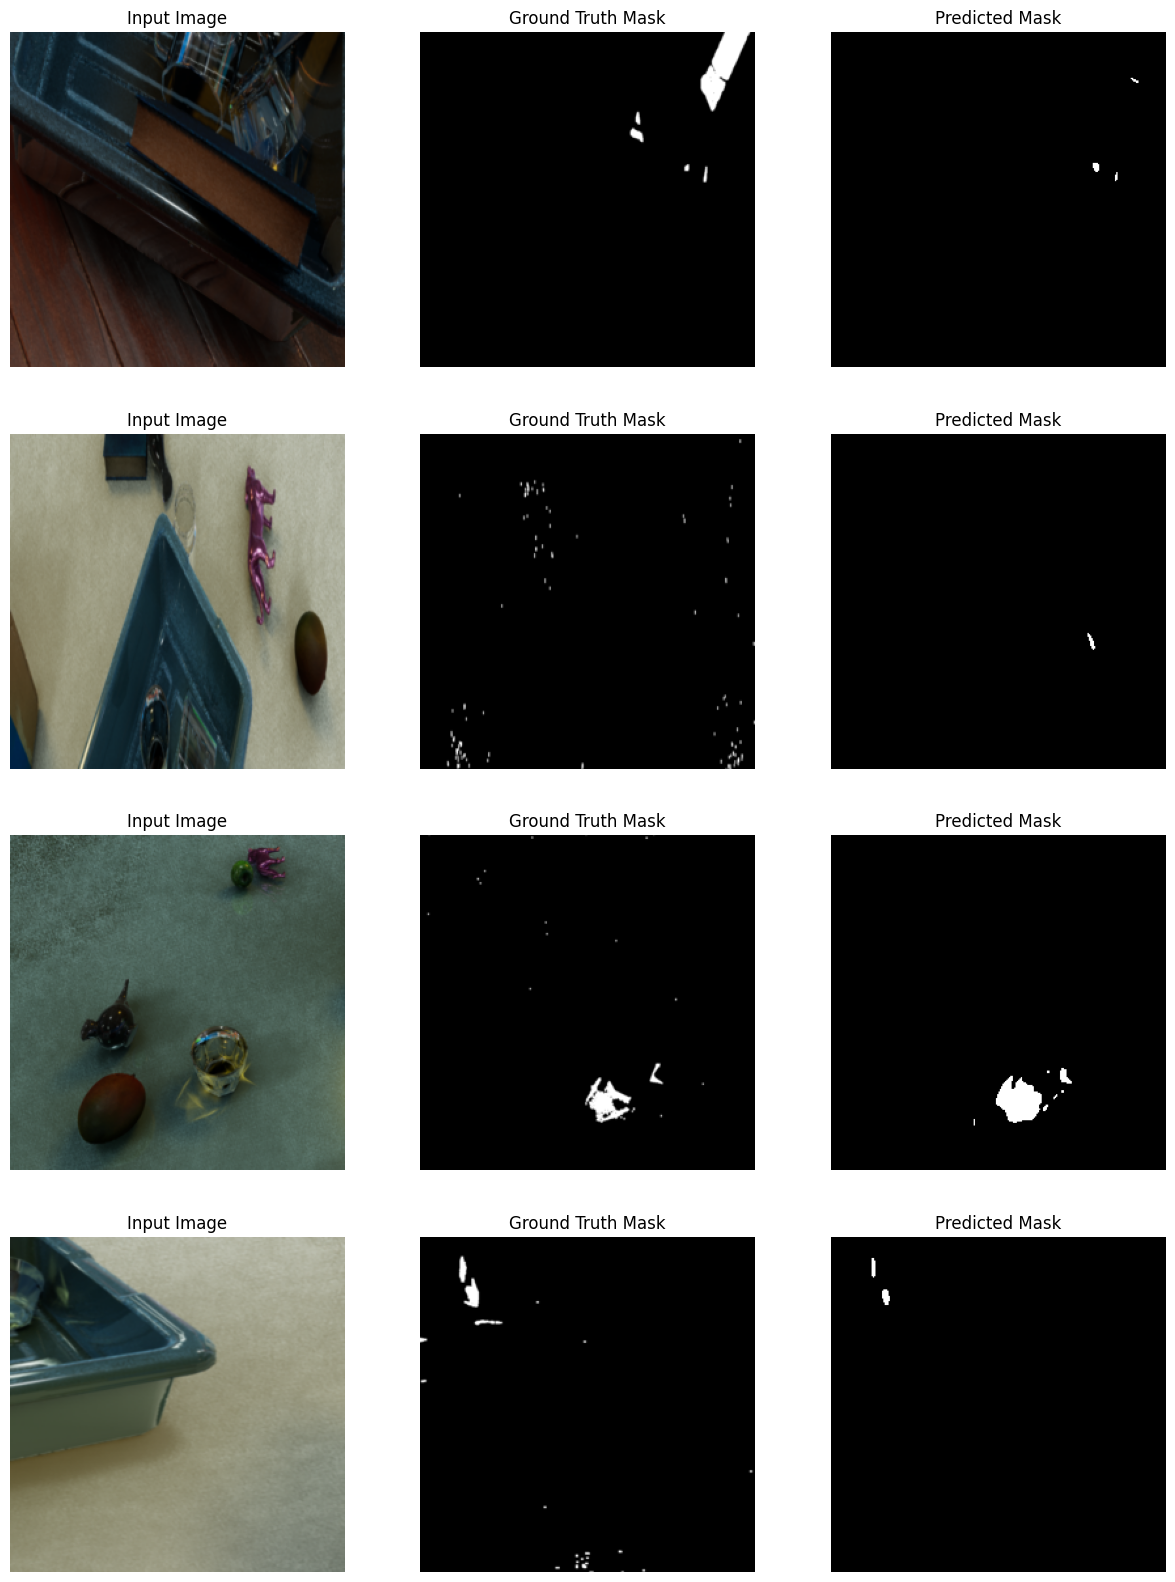

In [94]:
visualize_predictions(model, train_dataloader)

In [85]:
# Perform cross-validation and hyperparameter optimization
best_params, results = grid_search(param_grid, train_dataset, val_dataset)

2024-06-24 17:17:21,853 - Testing hyperparameters: {'lr': 0.001, 'batch_size': 4, 'optimizer': 'adam', 'weight_decay': 0, 'num_epochs': 10}
Epoch 1/10: 100%|██████████| 160/160 [00:27<00:00,  5.85it/s, loss=0.026] 
2024-06-24 17:17:49,226 - Epoch 1/10, Loss: 0.0665
Epoch 2/10: 100%|██████████| 160/160 [00:27<00:00,  5.87it/s, loss=0.0136]
2024-06-24 17:18:16,464 - Epoch 2/10, Loss: 0.0600
Epoch 3/10: 100%|██████████| 160/160 [00:27<00:00,  5.88it/s, loss=0.0175]
2024-06-24 17:18:43,698 - Epoch 3/10, Loss: 0.0581
Epoch 4/10: 100%|██████████| 160/160 [00:26<00:00,  6.14it/s, loss=0.0602]
2024-06-24 17:19:09,752 - Epoch 4/10, Loss: 0.0630
Epoch 5/10: 100%|██████████| 160/160 [00:26<00:00,  6.14it/s, loss=0.0348]
2024-06-24 17:19:35,800 - Epoch 5/10, Loss: 0.0667
Epoch 6/10: 100%|██████████| 160/160 [00:26<00:00,  5.97it/s, loss=0.108] 
2024-06-24 17:20:02,611 - Epoch 6/10, Loss: 0.0649
Epoch 7/10: 100%|██████████| 160/160 [00:26<00:00,  6.07it/s, loss=0.0481]
2024-06-24 17:20:28,970 - Epo

In [86]:
best_params

{'lr': 0.001,
 'batch_size': 8,
 'optimizer': 'adam',
 'weight_decay': 0,
 'num_epochs': 15}

In [115]:
# Train final model with best hyperparameters
final_model = UNet(n_channels=3, n_classes=1).to(device)
final_criterion = nn.BCEWithLogitsLoss()
final_optimizer = get_optimizer(best_params['optimizer'], final_model.parameters(), best_params['lr'], best_params['weight_decay'])

train_model(final_model, final_criterion, final_optimizer, train_dataloader, num_epochs=best_params['num_epochs'])

# Evaluate the final model on the test dataset
test_loss = evaluate_model(final_model, test_dataloader)
logging.info(f'Test Loss: {test_loss:.4f}')

Epoch 1/15: 100%|██████████| 160/160 [00:27<00:00,  5.84it/s, loss=0.0393]
2024-06-25 00:55:24,452 - Epoch 1/15, Loss: 0.1688
Epoch 2/15: 100%|██████████| 160/160 [00:30<00:00,  5.26it/s, loss=0.0417]
2024-06-25 00:55:54,872 - Epoch 2/15, Loss: 0.0694
Epoch 3/15: 100%|██████████| 160/160 [00:33<00:00,  4.82it/s, loss=0.0525]
2024-06-25 00:56:28,082 - Epoch 3/15, Loss: 0.0626
Epoch 4/15: 100%|██████████| 160/160 [00:33<00:00,  4.81it/s, loss=0.043] 
2024-06-25 00:57:01,372 - Epoch 4/15, Loss: 0.0658
Epoch 5/15: 100%|██████████| 160/160 [00:34<00:00,  4.59it/s, loss=0.0778]
2024-06-25 00:57:36,219 - Epoch 5/15, Loss: 0.0637
Epoch 6/15: 100%|██████████| 160/160 [00:34<00:00,  4.65it/s, loss=0.0531]
2024-06-25 00:58:10,628 - Epoch 6/15, Loss: 0.0654
Epoch 7/15: 100%|██████████| 160/160 [00:31<00:00,  5.07it/s, loss=0.021] 
2024-06-25 00:58:42,177 - Epoch 7/15, Loss: 0.0659
Epoch 8/15: 100%|██████████| 160/160 [00:33<00:00,  4.81it/s, loss=0.0567]
2024-06-25 00:59:15,454 - Epoch 8/15, Loss:

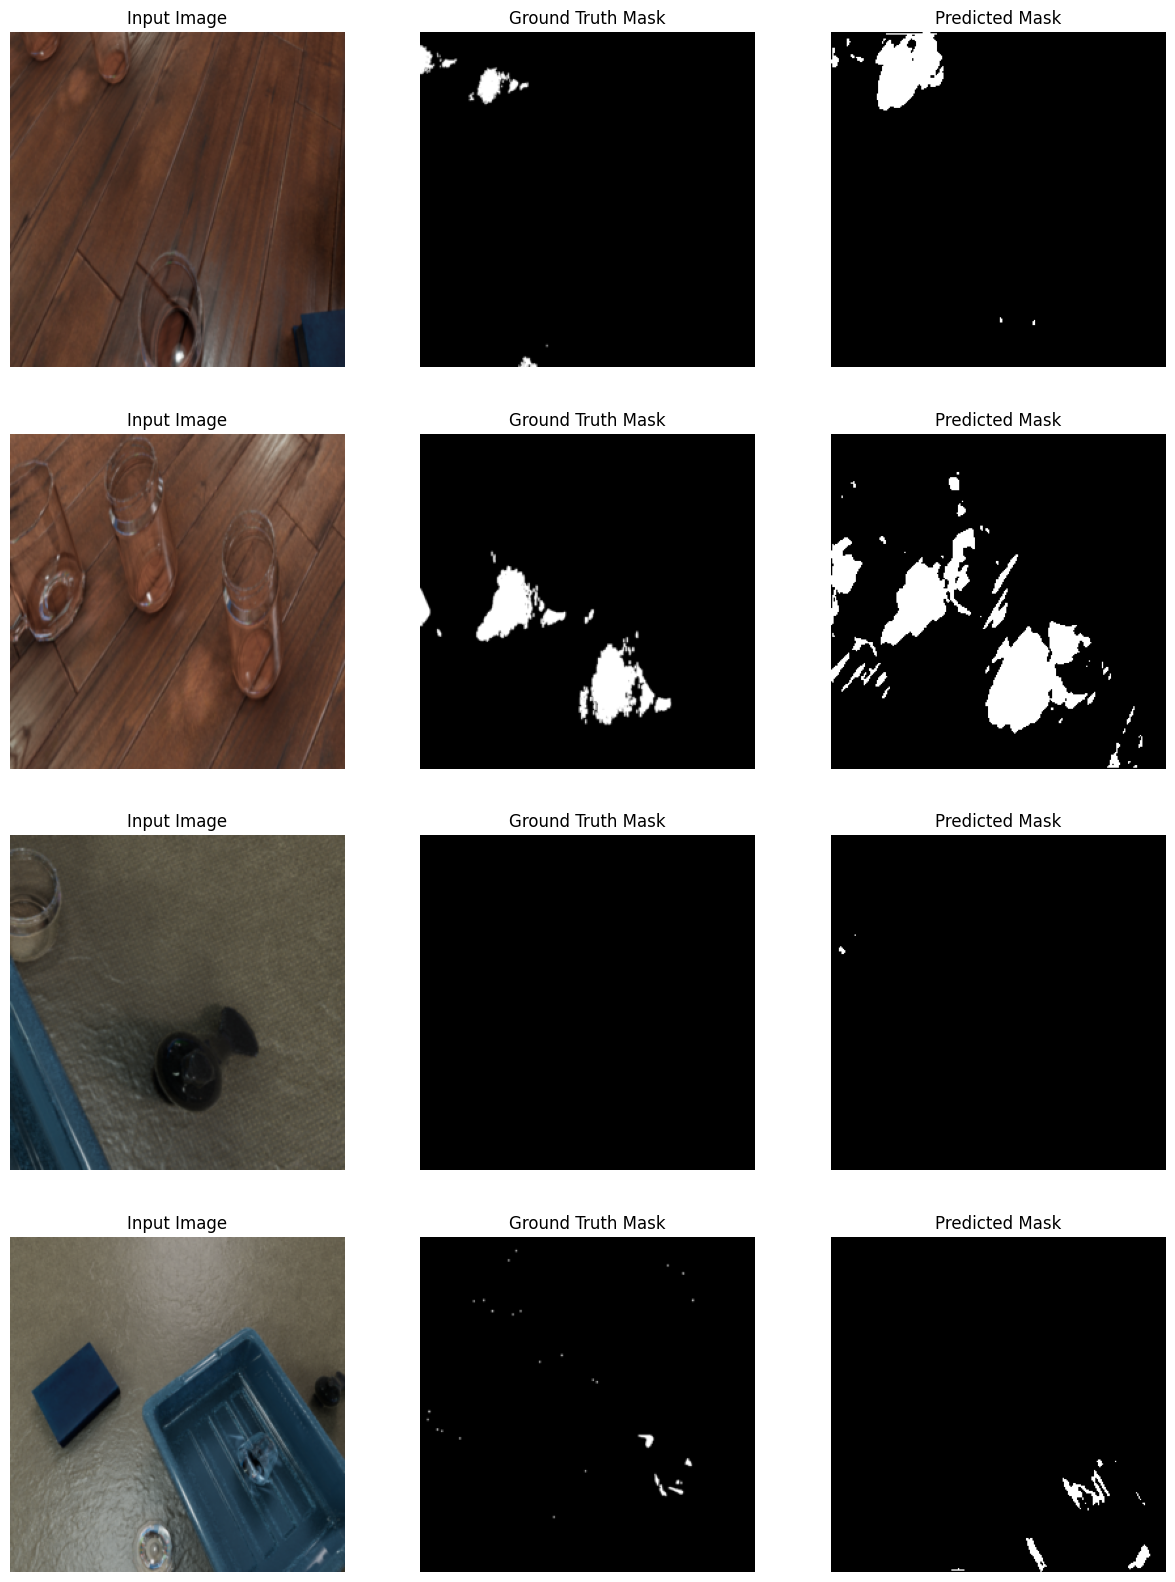

In [131]:
visualize_predictions(model, test_dataloader)

In [95]:
torch.save(model.state_dict(), 'trained_models/best_model.pth')